### Basic EDA

- sources
  - https://users.ics.aalto.fi/jesse/talks/Multilabel-Part01.pdf
  - https://users.ics.aalto.fi/jesse/talks/Multilabel-Part02.pdf   

##### TODO

- [ ] Explore labels dependence 

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_csv('../data/raw/PubMed Multi Label Text Classification Dataset Processed.csv', delimiter=',')

label_names = df.columns[6:] # ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z']
NUM_LABELS = len(label_names) # 14 classes (multilabel)

df['words_per_text'] = df['abstractText'].map(lambda sent: len(sent.split(' ')))

# create a column containing the 'one hot vector' label
df['label'] = df[label_names].apply(lambda row: list(row.values), axis=1)
df.head()

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,...,G,H,I,J,L,M,N,Z,words_per_text,label
0,Expression of p53 and coexistence of HPV in pr...,Fifty-four paraffin embedded tissue sections f...,"['DNA Probes, HPV', 'DNA, Viral', 'Female', 'H...",8549602,"[['D13.444.600.223.555', 'D27.505.259.750.600....","['Chemicals and Drugs [D]', 'Organisms [B]', '...",0,1,1,1,...,0,1,0,0,0,0,0,0,114,"[0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
1,Vitamin D status in pregnant Indian women acro...,The present cross-sectional study was conducte...,"['Adult', 'Alkaline Phosphatase', 'Breast Feed...",21736816,"[['M01.060.116'], ['D08.811.277.352.650.035'],...","['Named Groups [M]', 'Chemicals and Drugs [D]'...",0,1,1,1,...,1,0,1,1,0,1,1,1,249,"[0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]"
2,[Identification of a functionally important di...,The occurrence of individual amino acids and d...,"['Amino Acid Sequence', 'Analgesics, Opioid', ...",19060934,"[['G02.111.570.060', 'L01.453.245.667.060'], [...","['Phenomena and Processes [G]', 'Information S...",1,1,0,1,...,1,0,0,0,1,0,0,0,106,"[1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
3,Multilayer capsules: a promising microencapsul...,"In 1980, Lim and Sun introduced a microcapsule...","['Acrylic Resins', 'Alginates', 'Animals', 'Bi...",11426874,"[['D05.750.716.822.111', 'D25.720.716.822.111'...","['Chemicals and Drugs [D]', 'Technology, Indus...",1,1,1,1,...,1,0,0,1,0,0,0,0,265,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]"
4,"Nanohydrogel with N,N'-bis(acryloyl)cystine cr...",Substantially improved hydrogel particles base...,"['Antineoplastic Agents', 'Cell Proliferation'...",28323099,"[['D27.505.954.248'], ['G04.161.750', 'G07.345...","['Chemicals and Drugs [D]', 'Phenomena and Pro...",1,1,0,1,...,1,0,0,1,0,0,0,0,234,"[1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]"


In [10]:
df.isnull().sum() # to title contains 2 NaN values

Title             2
abstractText      0
meshMajor         0
pmid              0
meshid            0
meshroot          0
A                 0
B                 0
C                 0
D                 0
E                 0
F                 0
G                 0
H                 0
I                 0
J                 0
L                 0
M                 0
N                 0
Z                 0
words_per_text    0
label             0
dtype: int64

In [11]:
df[label_names].sum()

A    23263
B    46577
C    26453
D    31074
E    39202
F     8885
G    33609
H     6069
I     5595
J     5531
L     7503
M    21363
N    22919
Z     8049
dtype: int64

In [12]:
print(f"Mean sentence length (words): {df['words_per_text'].mean()}")
print(f"Median sentence length (words): {df['words_per_text'].quantile(0.5)}")
print(f"80% quantile sentence length (words): {df['words_per_text'].quantile(0.8)}")

Mean sentence length (words): 191.57676
Median sentence length (words): 194.0
80% quantile sentence length (words): 250.0


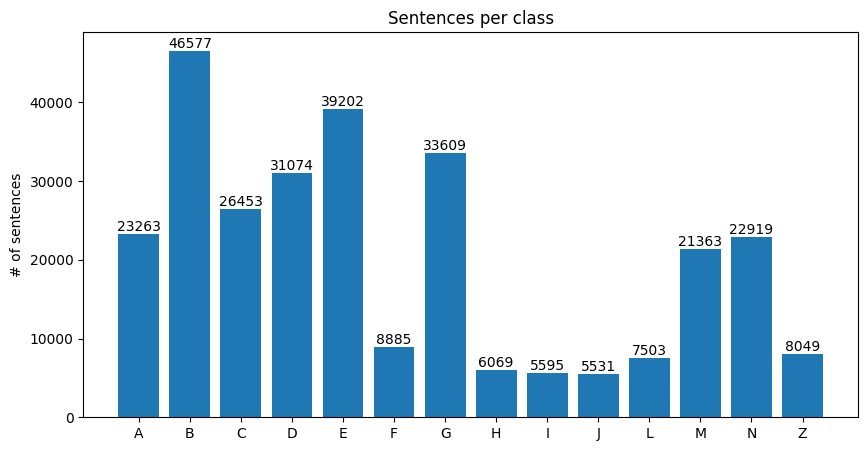

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
bar = ax.bar(label_names, df[label_names].sum()) # / df[label_names].sum().sum()
ax.bar_label(bar, label_type='edge')
ax.set_ylabel('# of sentences') # % of sentences
ax.set_title('Sentences per class')

plt.show()

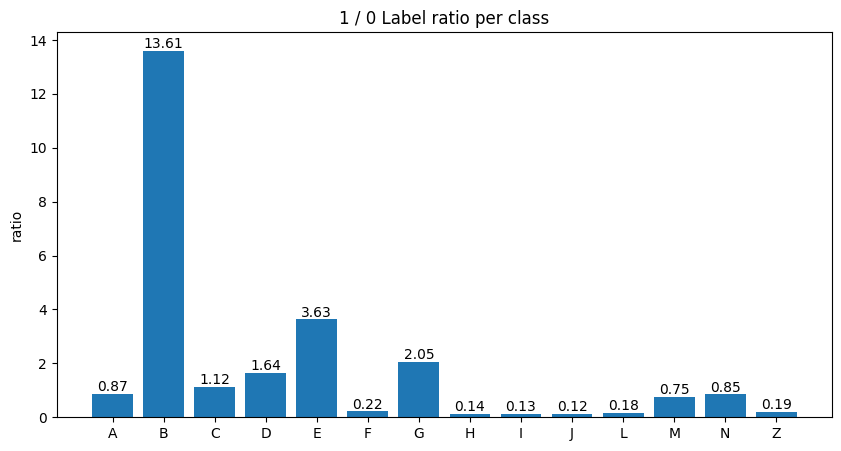

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
b = ax.bar(label_names, df[label_names].sum() / (df[label_names]==0).astype(int).sum()) # / df[label_names].sum().sum()
ax.bar_label(b, label_type='edge', fmt="{:.2f}")
ax.set_ylabel('ratio') # % of sentences
ax.set_title('1 / 0 Label ratio per class')

plt.show()

### Train - dev - test split

##### Make sure splitting keeps roughly the same propotion of samples from each label in each of the splits

In [17]:
# I use the labels with the most positive samples for strafity in order to keep splitting as balanced as possible
# NOTE: even with stratify=None the splitting seems to be pretty balanced!
train_df, test_df = train_test_split(df, train_size=0.9, test_size=0.1, random_state=1, stratify=df[['B', 'D', 'E', 'G']], shuffle=True) # stratify=df[['B', 'D', 'E', 'G']]
len(train_df) , len(test_df)

(45000, 5000)

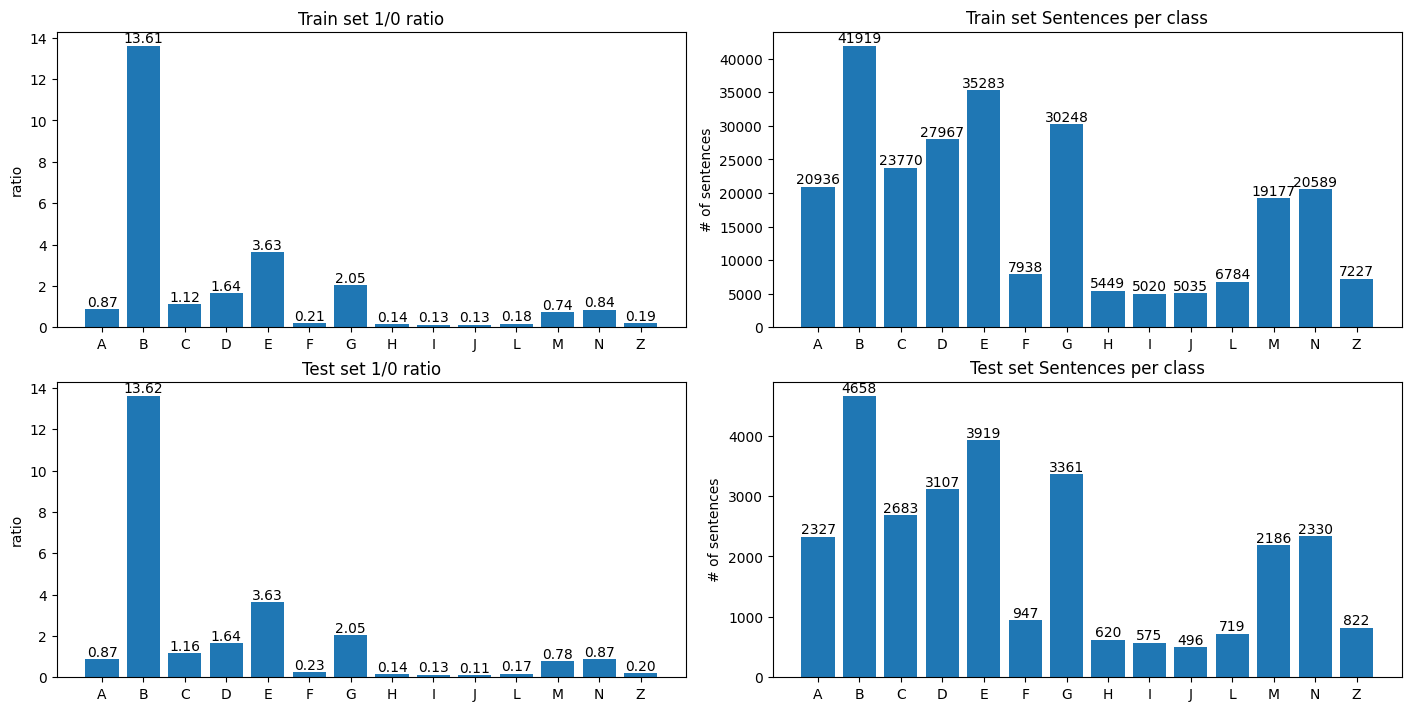

In [21]:
fig, ax = plt.subplots(2,2, figsize=(14, 7), layout='constrained')
b = ax[0][0].bar(label_names, train_df[label_names].sum() / (train_df[label_names]==0).sum()) # / df[label_names].sum().sum()
ax[0][0].bar_label(b, label_type='edge', fmt="{:.2f}")
ax[0][0].set_ylabel('ratio') # % of sentences
ax[0][0].set_title('Train set 1/0 ratio')

b = ax[1][0].bar(label_names, test_df[label_names].sum() / (test_df[label_names]==0).sum()) # / df[label_names].sum().sum()
ax[1][0].bar_label(b, label_type='edge', fmt="{:.2f}")
ax[1][0].set_ylabel('ratio') # % of sentences
ax[1][0].set_title('Test set 1/0 ratio')

b = ax[0][1].bar(label_names, train_df[label_names].sum()) # / df[label_names].sum().sum()
ax[0][1].bar_label(b, label_type='edge')
ax[0][1].set_ylabel('# of sentences') # % of sentences
ax[0][1].set_title('Train set Sentences per class')

b = ax[1][1].bar(label_names, test_df[label_names].sum()) # / df[label_names].sum().sum()
ax[1][1].bar_label(b, label_type='edge')
ax[1][1].set_ylabel('# of sentences') # % of sentences
ax[1][1].set_title('Test set Sentences per class')
plt.show()